# Hansen (2015) RDD Replication

## Paper summary

*Briefly summarize this paper.  What is his research question? What data does he use?  What is his research design, or “identification strategy”?  What are his conclusions?*

## Setup

In [49]:
install.packages("tidymodels")
install.packages("rdd")
install.packages("rdrobust")

Installing package into ‘/Users/scottcohn/Library/R/4.0/library’
(as ‘lib’ is unspecified)




The downloaded binary packages are in
	/var/folders/n2/_7r9g5mj1zvc314ypm535vjm0000gn/T//RtmpVUNrJP/downloaded_packages


In [50]:
## libs

library(tidyverse)
library(modelsummary)
library(sandwich)
library(lmtest)
library(rdd)
library(rdrobust)
library(knitr)
library(broom)
library(tidymodels)

In [4]:
## funcs

read_data <- function(df)
{
  full_path <- paste("https://raw.githubusercontent.com/scottcohn97/hansen2015_RDD_replication/main/Data/", 
                     df, sep = "")
  df <- read_csv(full_path)
  return(df)
}

In [5]:
## load data

dwi <- read_data("hansen_dwi.csv")

Parsed with column specification:
cols(
  Date = col_character(),
  Alcohol1 = col_double(),
  Alcohol2 = col_double(),
  low_score = col_double(),
  male = col_double(),
  white = col_double(),
  recidivism = col_double(),
  acc = col_double(),
  aged = col_double(),
  year = col_double(),
  bac1 = col_double(),
  bac2 = col_double()
)



In [10]:
dwi %>% colnames()

[1] "Date"        "Alcohol1"    "Alcohol2"    "low_score"   "male"       
 [6] "white"       "recidivism"  "acc"         "aged"        "year"       
[11] "bac1"        "bac2"        "bac1_binary"

## Reproducing

*In the United States, an officer can arrest a driver if after giving them a blood alcohol content (BAC) test they learn the driver had a BAC of 0.08 or higher. We will only focus on the 0.08 BAC cutoff. We will be ignoring the 0.15 cutoff for all this analysis. Create a dummy equaling 1 if `bac1` >= 0.08 and 0 otherwise in your do file or R file*

In [6]:
## tidy

dwi <- dwi %>% 
  # create binary for cutoff
  mutate(dui = if_else(bac1 >= 0.08, 1, 0)) 

### Figure 1

*The first thing to do in any RDD is look at the raw data and see if there’s any evidence for manipulation (“sorting on the running variable”). If people were capable of manipulating their blood alcohol content (`bac1`), describe the test we would use to check for this.  Now evaluate whether you see this in these data?  Either recreate Figure 1 using the `bac1` variable as your measure of blood alcohol content or use your own density test from software.  Do you find evidence for sorting on the running variable? Explain your results.  Compare what you found to what Hansen found.*

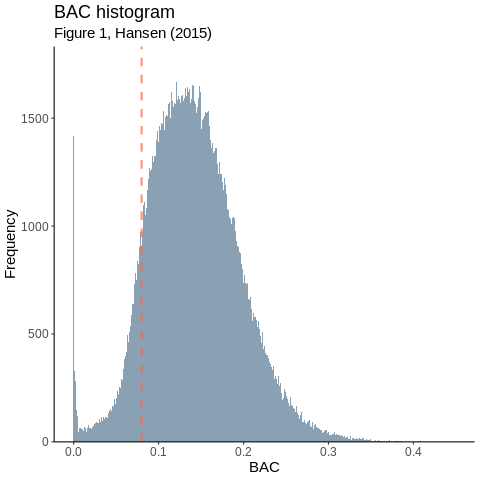

In [51]:
## Fig 1

dwi %>%
  ggplot(aes(x = bac1)) +
  geom_histogram(binwidth = 0.001, fill = "#8aa1b4") +
  geom_vline(aes(xintercept = 0.08), size = 1, linetype = 2,
             color = "tomato", alpha = 0.7) +
  labs(x = "BAC",
       y = "Frequency",
       title = "BAC histogram",
       subtitle = "Figure 1, Hansen (2015)") +
  scale_y_continuous(expand = expansion(mult = c(0, .1))) +
  theme_classic() + 
  theme(axis.text = element_text(size = 12),
        axis.title = element_text(size = 15),
        title = element_text(size = 15))

From the distribution of blood alcohol content (BAC), we see little to no evidence of endogenous sorting. There appears to be no non-random heaping that might bias the RDD. This aligns exactly with what Hansen (2015) found.

### Table 2

*The second thing we need to do is check for covariate balance. Recreate Table 2 Panel A but only white male, age and accident (`acc`) as dependent variables.  Use your equation (1) for this. Are the covariates balanced at the cutoff?  It’s okay if they are not exactly the same as Hansen’s.*

Equation 1:

$$y_i = X_i' \gamma + \alpha_1 \textrm{DUI}_i + \alpha_2 \textrm{BAC}_i \times \textrm{DUI}_i + u_i,$$

where $y_i$ is a measure of recidivism, $X_i$ is a vector of controls, and the BAC variable is rescaled around the relevant threshold.


In [51]:
## RDD

rdr <- rdrobust(y = dwi$recidivism,
                x = dwi$white, c = 0.08)
summary(rdr)

[1] "Mass points detected in the running variable."


ERROR: Error in chol.default(crossprod(x)): the leading minor of order 3 is not positive definite


In [97]:
## RDD (sharp)

# allow slopes to vary
dwi_rdd <- dwi %>%
    drop_na(any_of("recidivism")) %$% 
    lm(recidivism ~ white + male + aged + acc + dui + I(bac1 * dui)) 
    # lm(y ~ white + male + aged + acc + dui + I(bac1 - 0.001)) 

dwi_rdd %>%
    summary()


Call:
lm(formula = recidivism ~ white + male + aged + acc + dui + I(bac1 * 
    dui))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.22762 -0.12855 -0.11455 -0.09614  0.95395 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    1.145e-01  3.678e-03  31.131  < 2e-16 ***
white          3.641e-03  2.016e-03   1.806 0.070845 .  
male           2.902e-02  1.704e-03  17.026  < 2e-16 ***
aged          -6.421e-04  6.084e-05 -10.554  < 2e-16 ***
acc           -7.550e-03  1.981e-03  -3.811 0.000138 ***
dui           -5.289e-02  3.306e-03 -15.997  < 2e-16 ***
I(bac1 * dui)  3.523e-01  1.599e-02  22.026  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3215 on 214551 degrees of freedom
Multiple R-squared:  0.003919,	Adjusted R-squared:  0.003891 
F-statistic: 140.7 on 6 and 214551 DF,  p-value: < 2.2e-16


In [53]:
# bandwidth
bw <- with(dwi, IKbandwidth(bac1, recidivism, cutpoint = 0.08))

# kernel weights
dwi$wt <- kernelwts(dwi$bac1, center = 0.08, bw = bw, kernel = "rectangular")

# models
MATE_model_male <- lm(recidivism ~ dui + bac1 + dui * bac1 + male, 
                 weights = wt, data = subset(dwi, wt > 0))

MATE_model_white <- lm(recidivism ~ dui + bac1 + dui * bac1 + white, 
                 weights = wt, data = subset(dwi, wt > 0))


MATE_model_aged <- lm(recidivism ~ dui + bac1 + dui * bac1 + aged, 
                 weights = wt, data = subset(dwi, wt > 0))

MATE_model_acc <- lm(recidivism ~ dui + bac1 + dui * bac1 + acc, 
                 weights = wt, data = subset(dwi, wt > 0))

# return coef

print("MALE")
coeftest(MATE_model_male, vcov. = vcovHC(MATE_model, type = "HC1"))

print("WHITE")
coeftest(MATE_model_white, vcov. = vcovHC(MATE_model, type = "HC1"))

print("AGED")
coeftest(MATE_model_aged, vcov. = vcovHC(MATE_model, type = "HC1"))

print("ACCIDENT")
coeftest(MATE_model_acc, vcov. = vcovHC(MATE_model, type = "HC1"))


t test of coefficients:

             Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  0.112384   0.018013  6.2390 4.429e-10 ***
dui         -0.067943   0.022303 -3.0464  0.002317 ** 
bac1        -0.321189   0.259759 -1.2365  0.216281    
dui:bac1     0.611845   0.292332  2.0930  0.036355 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



t test of coefficients:

              Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  0.1294765  0.0180130  7.1879 6.646e-13 ***
dui         -0.0694596  0.0223030 -3.1144  0.001844 ** 
bac1        -0.3330882  0.2597592 -1.2823  0.199743    
white        0.0129428  0.0032251  4.0131 5.999e-05 ***
dui:bac1     0.6318084  0.2923318  2.1613  0.030678 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



t test of coefficients:

             Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  0.170123   0.018013  9.4444 < 2.2e-16 ***
dui         -0.073356   0.022303 -3.2891  0.001006 ** 
bac1        -0.381400   0.259759 -1.4683  0.142032    
dui:bac1     0.680838   0.292332  2.3290  0.019863 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



t test of coefficients:

             Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  0.140427   0.018013  7.7959 6.488e-15 ***
dui         -0.069473   0.022303 -3.1150   0.00184 ** 
bac1        -0.333599   0.259759 -1.2843   0.19905    
dui:bac1     0.633149   0.292332  2.1659   0.03033 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [43]:
dwi_rd_male <- RDestimate(recidivism ~ bac1 | male, data = dwi, cutpoint = 0.08, 
           bw = bw, kernel = "rectangular", cluster = dwi$dui)

summary(dwi_rd_male)


Call:
RDestimate(formula = recidivism ~ bac1 | male, data = dwi, cutpoint = 0.08, 
    bw = bw, kernel = "rectangular", cluster = dwi$dui)

Type:
sharp 

Estimates:
           Bandwidth  Observations  Estimate  Std. Error  z value  Pr(>|z|)
LATE       0.03668     66244        -0.01900  2.304e-05   -824.4   0       
Half-BW    0.01834     34736        -0.01740  6.729e-05   -258.5   0       
Double-BW  0.07336    128204        -0.02344  4.216e-05   -556.0   0       
              
LATE       ***
Half-BW    ***
Double-BW  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

F-statistics:
           F      Num. DoF  Denom. DoF  p
LATE       46.29  4          66239      0
Half-BW    26.71  4          34731      0
Double-BW  75.32  4         128199      0


In [44]:
dwi_rd_white <- RDestimate(recidivism ~ bac1 | white, data = dwi, cutpoint = 0.08, 
           bw = bw, kernel = "rectangular", cluster = dwi$dui)

summary(dwi_rd_white)


Call:
RDestimate(formula = recidivism ~ bac1 | white, data = dwi, cutpoint = 0.08, 
    bw = bw, kernel = "rectangular", cluster = dwi$dui)

Type:
sharp 

Estimates:
           Bandwidth  Observations  Estimate  Std. Error  z value  Pr(>|z|)
LATE       0.03668     66244        -0.01891  3.634e-05    -520.5  0       
Half-BW    0.01834     34736        -0.01785  2.820e-05    -632.9  0       
Double-BW  0.07336    128204        -0.02305  9.857e-06   -2338.5  0       
              
LATE       ***
Half-BW    ***
Double-BW  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

F-statistics:
           F       Num. DoF  Denom. DoF  p        
LATE       15.226  4          66239      3.796e-12
Half-BW     9.897  4          34731      1.063e-07
Double-BW  22.999  4         128199      0.000e+00


In [46]:
dwi_rd_aged <- RDestimate(recidivism ~ bac1 | aged, data = dwi, cutpoint = 0.08, 
           bw = bw, kernel = "rectangular", cluster = dwi$dui)

summary(dwi_rd_aged)


Call:
RDestimate(formula = recidivism ~ bac1 | aged, data = dwi, cutpoint = 0.08, 
    bw = bw, kernel = "rectangular", cluster = dwi$dui)

Type:
sharp 

Estimates:
           Bandwidth  Observations  Estimate  Std. Error  z value  Pr(>|z|)
LATE       0.03668     66244        -0.01889  5.938e-06   -3181    0       
Half-BW    0.01834     34736        -0.01776  6.039e-06   -2941    0       
Double-BW  0.07336    128204        -0.02327  8.116e-06   -2867    0       
              
LATE       ***
Half-BW    ***
Double-BW  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

F-statistics:
           F      Num. DoF  Denom. DoF  p        
LATE       25.21  4          66239      0.000e+00
Half-BW    13.25  4          34731      1.739e-10
Double-BW  40.74  4         128199      0.000e+00


In [48]:
dwi_rd_acc <- RDestimate(recidivism ~ bac1 | acc, data = dwi, cutpoint = 0.08, 
           bw = bw, kernel = "rectangular", cluster = dwi$dui)

summary(dwi_rd_acc)


Call:
RDestimate(formula = recidivism ~ bac1 | acc, data = dwi, cutpoint = 0.08, 
    bw = bw, kernel = "rectangular", cluster = dwi$dui)

Type:
sharp 

Estimates:
           Bandwidth  Observations  Estimate  Std. Error  z value   Pr(>|z|)
LATE       0.03668     66244        -0.01882  8.817e-06    -2134.5  0       
Half-BW    0.01834     34736        -0.01774  1.857e-07   -95541.3  0       
Double-BW  0.07336    128204        -0.02303  2.542e-05     -906.2  0       
              
LATE       ***
Half-BW    ***
Double-BW  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

F-statistics:
           F       Num. DoF  Denom. DoF  p        
LATE       11.501  4          66239      4.953e-09
Half-BW     7.556  4          34731      8.866e-06
Double-BW  18.213  4         128199      1.155e-14


In [61]:
## Table 2

modelsummary(dwi_rdd)

ERROR: Error in modelsummary_wide(dwi_rdd): could not find function "modelsummary_wide"


### Figure 2 Panels A-D

*Recreate Figure 2 panel A-D. You can use the -cmogram- command in Stata to do this. Fit both linear and quadratic with confidence intervals. Discuss what you find and compare it with Hansen’s paper.*

In [ ]:
# Figure 2 Panel A - Accident at scene

In [ ]:
# Figure 2 Panel B - Male

In [ ]:
# Figure 2 Panel C - Age

In [ ]:
# Figure 2 Panel D - White

### Table 3, Col 1, Panel A + B

*Estimate equation (1) with recidivism (`recid`) as the outcome. This corresponds to Table 3 column 1, but since I am missing some of his variables, your sample size will be the entire dataset of 214,558. Nevertheless, replicate Table 3, column 1, Panels A and B.  Note that these are local linear regressions and Panel A uses as its bandwidth 0.03 to 0.13.  But Panel B has a narrower bandwidth of 0.055 to 0.105.  Your table should have three columns and two A and B panels associated with the different bandwidths.:*

1. *Column 1: control for the `bac1` linearly*
2. *Column 2: interact `bac1` with cutoff linearly*
3. *Column 3: interact `bac1` with cutoff linearly and as a quadratic*
4. *For all analysis, estimate uncertainty using heteroskedastic robust standard errors. [ed: But if you want to show off, use Kolesár and Rothe’s 2018 “honest” confidence intervals (only available in R).]*


### Figure 3

*Recreate the top panel of Figure 3 according to the following rule:*

1. *Fit linear fit using only observations with less than 0.15 bac on the `bac1`*
2. *Fit quadratic fit using only observations with less than 0.15 bac on the `bac1`*

### Reflecting on exercise

*Discuss what you learned from this exercise. What was the hypothesis you tested and what did you find?  How confident are you in Hansen’s original conclusion? Why/why not?*